# Solving Differential Equation using Neural Networks

First Equation to Solve:

$$
\frac{dy}{dx} + 0.1t - \sin (\pi * t/2) = 0 
$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Exact Solution using numerical integration


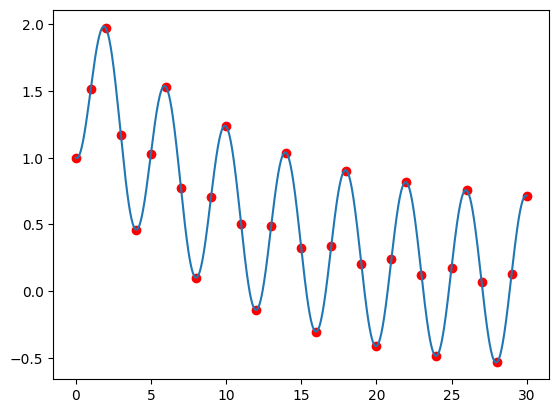

In [3]:
def rk4(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_ode(f, t0, y0, t_end, h):
    t_values = np.arange(t0, t_end + h, h)
    y_values = np.zeros((len(t_values),) + np.shape(y0))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4(f, t_values[i - 1], y_values[i - 1], h)

    return t_values, y_values

def dy_dt(t, y):
    return np.sin(np.pi * t / 2 ) - 1/10 * y

t_values, y_values = solve_ode(dy_dt, 0, 1, 30, 0.01)

t_train = t_values[::100]
y_train = y_values[::100]

plt.plot(t_values, y_values)
plt.scatter(t_train, y_train, c='red')
plt.show()

## Use a neural network with no "physical" information

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class NN(nn.Module):
    def __init__(self, n_input=1, n_output=1, hidden_dim=32):

        super().__init__()

        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(n_input, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x
    
def plot_result(x, y, x_data, y_data, yh, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(
        x,
        y,
        color="blue",
        linewidth=2,
        alpha=0.8,
        linestyle="--",
        label="Exact solution",
    )
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label="Training data")
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=30,
            color="tab:green",
            alpha=0.4,
            label="Collocation points",
        )
    leg = plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.setp(leg.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    plt.text(2.965, 1.95, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.ylabel("y", fontsize="xx-large")
    plt.xlabel("Time", fontsize="xx-large")
    plt.axis("on")

t_values = torch.from_numpy(t_values).float()
y_values = torch.from_numpy(y_values).float()
t_train = torch.from_numpy(t_train).float()
y_train = torch.from_numpy(y_train).float()


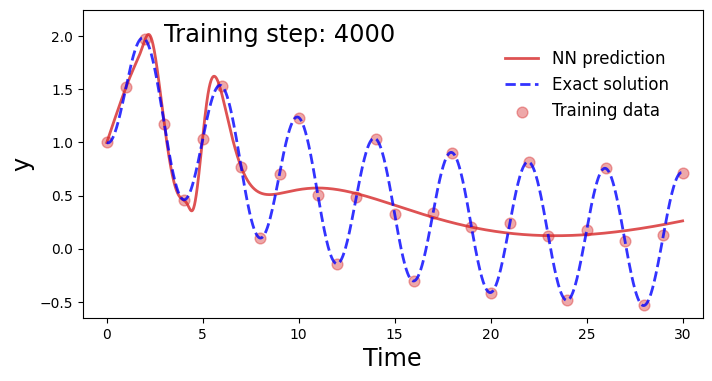

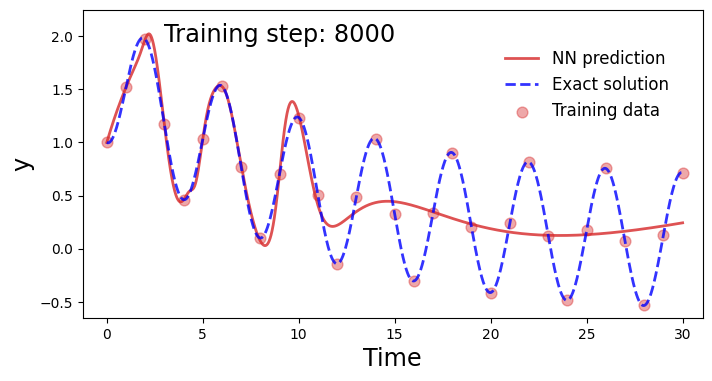

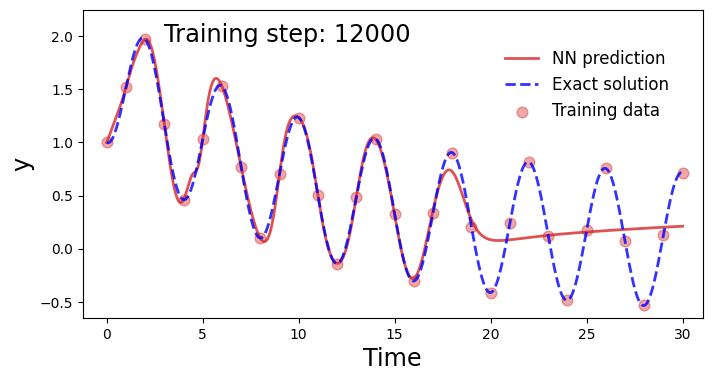

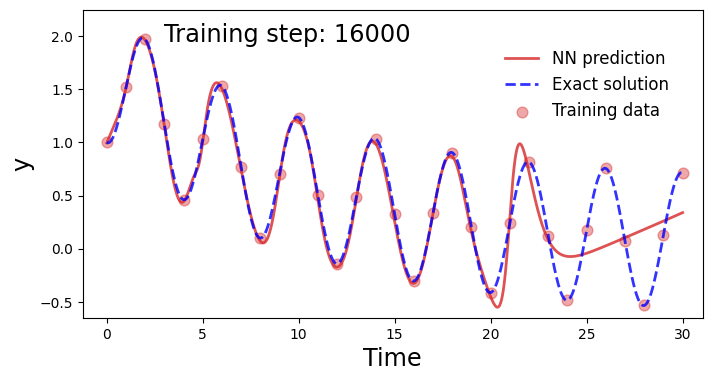

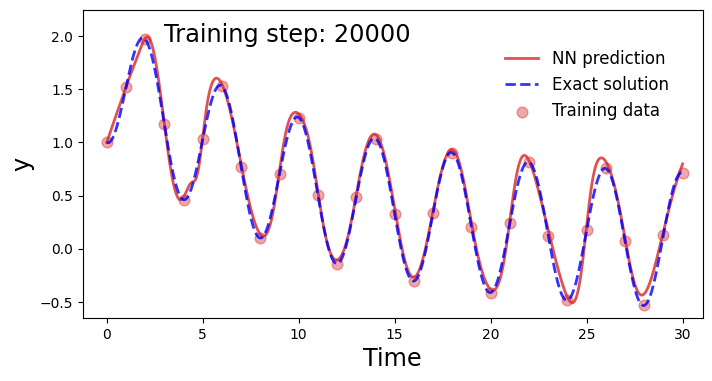

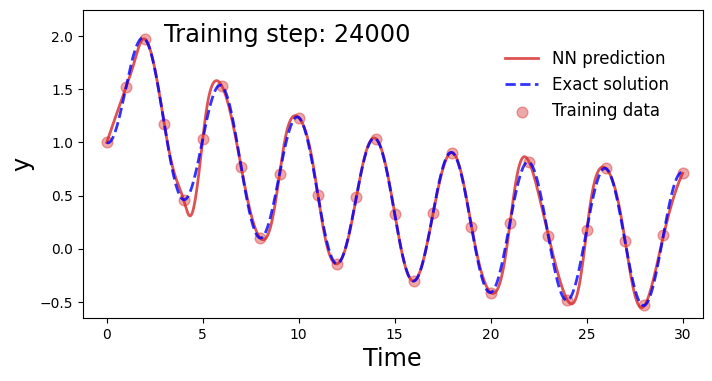

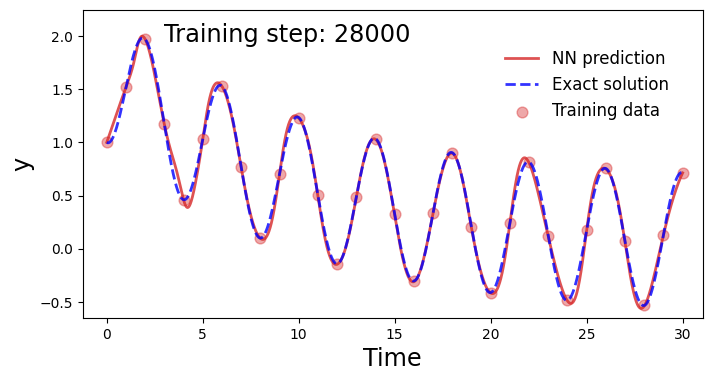

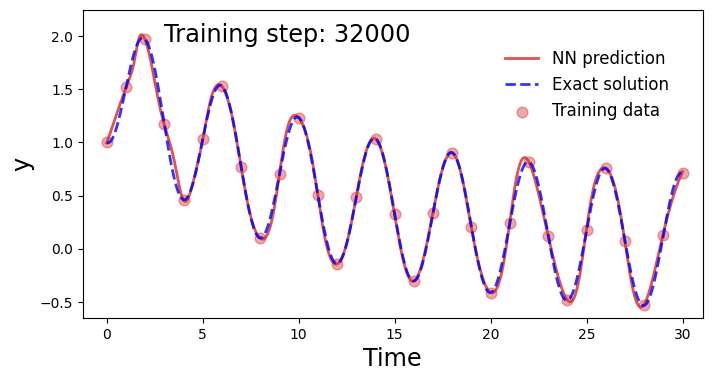

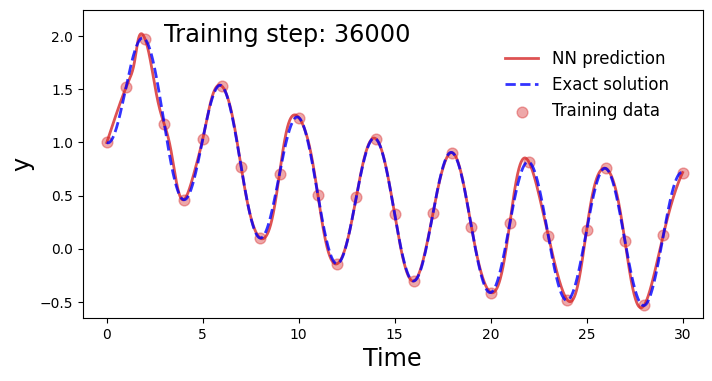

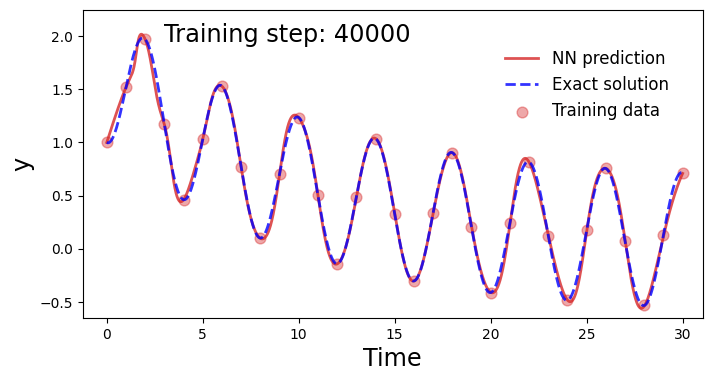

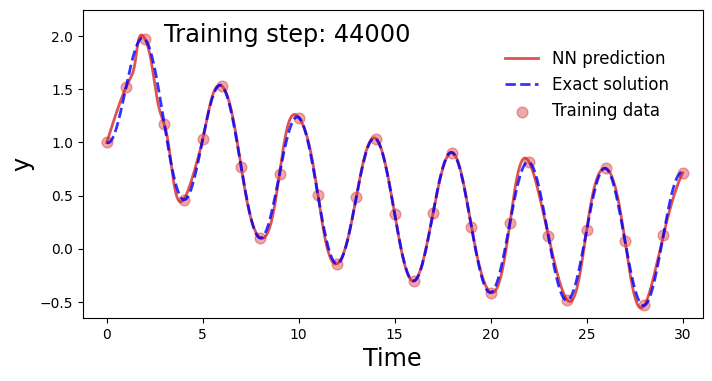

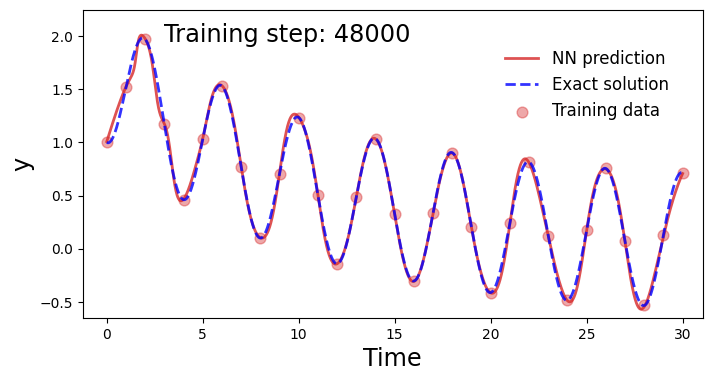

/var/folders/qc/h4k546bs6j9bl76bcjwyw5cw0000gn/T/ipykernel_37905/329073061.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


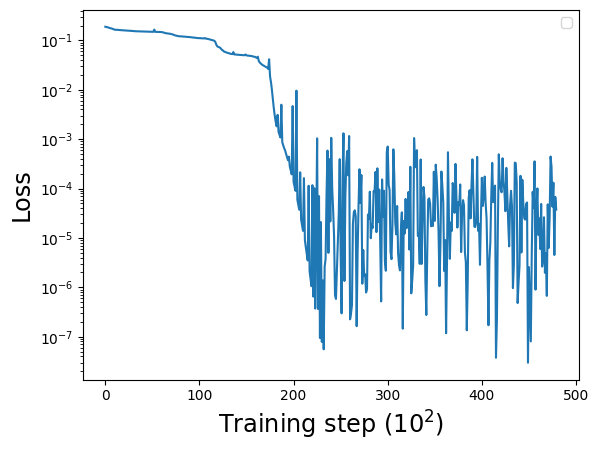

In [5]:
torch.manual_seed(123)
model = NN()
optimiser = optim.Adam(model.parameters(), lr=3e-3)

files = []
loss11_history = []

for i in range(48000):
    yh = model(t_train.unsqueeze(1)).squeeze()
    loss = torch.mean((yh - y_train) ** 2)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (i + 1) % 100 == 0:
        loss11_history.append(loss.detach())

        if (i + 1) % 4000 == 0:
            yh = model(t_values.unsqueeze(1)).detach()

            plot_result(t_values, y_values, t_train, y_train, yh)
            plt.show()
        else:
            plt.close("all")

fig11 = plt.figure(11)
plt.plot(loss11_history)
plt.xlabel("Training step ($10^2$)", fontsize="xx-large")
plt.ylabel("Loss", fontsize="xx-large")
plt.yscale("log")
plt.legend()


## Using a physical loss on the neural network

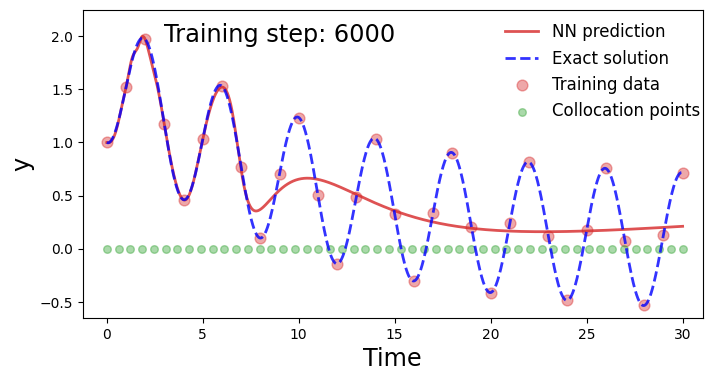

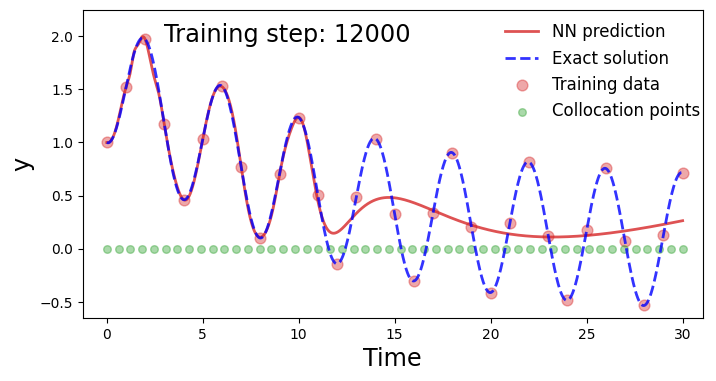

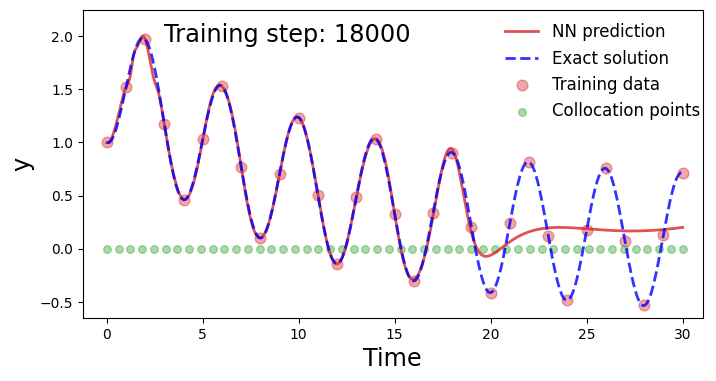

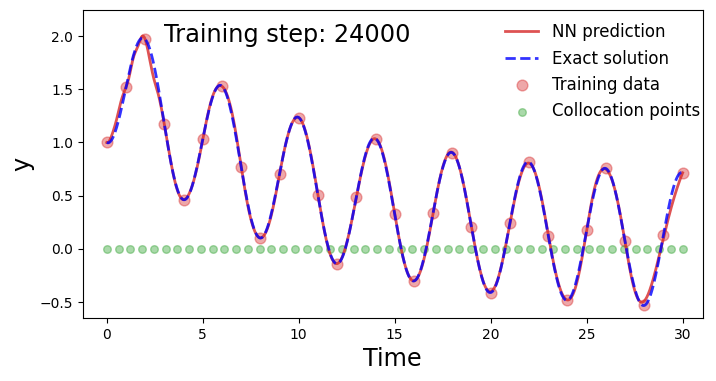

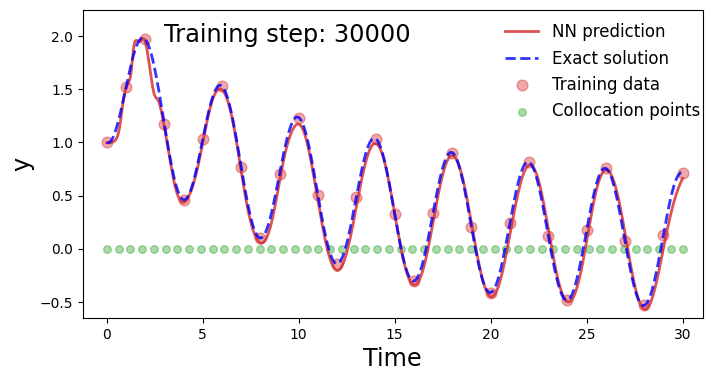

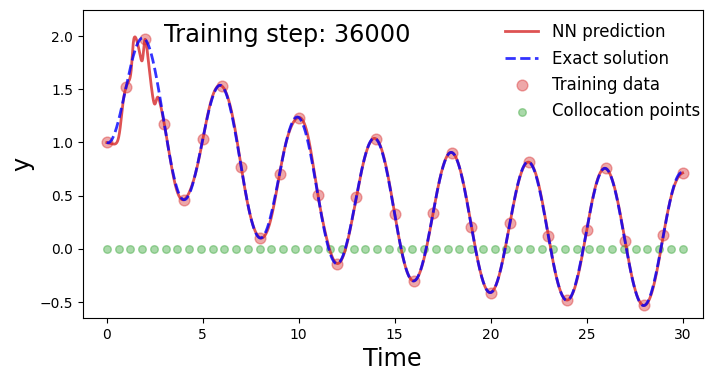

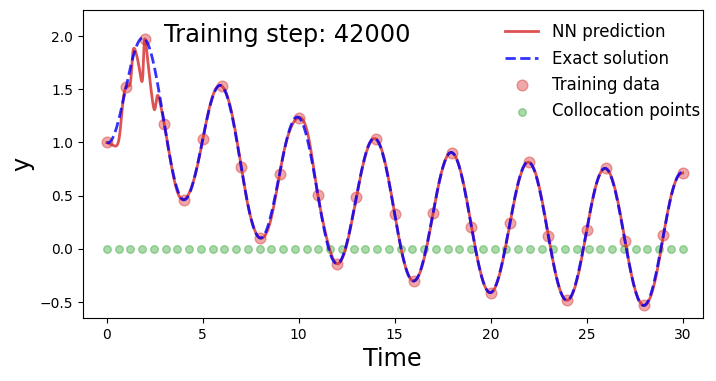

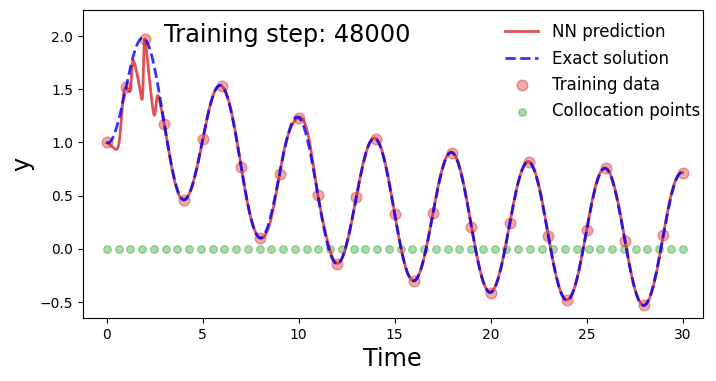

In [6]:
t_physics = torch.linspace(0, 30, 50).unsqueeze(1).requires_grad_(True)
lam = 0.1

torch.manual_seed(123)
model = NN()
optimiser = torch.optim.Adam(model.parameters(), lr=3e-3)

loss_history = []
loss2_history = []

for i in range(48000):

    optimiser.zero_grad()

    yh = model(t_train.unsqueeze(1)).squeeze()
    loss1 = 1.*torch.mean((yh-y_train)**2)

    yhp = model(t_physics.unsqueeze(1)).squeeze()
    dx = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]

    physics = dx + lam * yhp - torch.sin(np.pi * t_physics / 2)
    loss2 = (6e-2) * (torch.mean(physics**2))

    loss = loss1 + loss2
    loss.backward()
    optimiser.step()
    
    
    # We plot the result as training progresses ....................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())

        yh = model(t_values.unsqueeze(1)).detach().squeeze()
        xp = t_physics.detach()        
        plot_result(t_values, y_values, t_train, y_train, yh, xp)

                
        if (i+1) % 6000 == 0: 
            plt.show()
        else: 
            plt.close("all")
            
